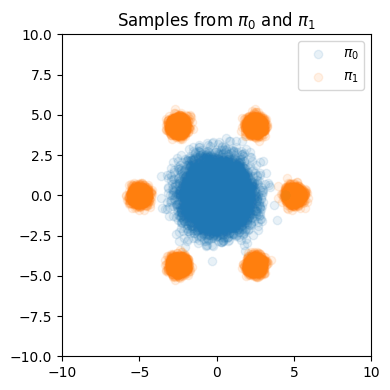

In [1]:
##### Question 1 #####
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
import matplotlib.pyplot as plt

def sample_gaussian_mixture(pis, d, mus, sigmas, num_samples=10000):
    # Determine the component for each sample
    categories = torch.distributions.Categorical(pis)
    components = categories.sample((num_samples,))

    # Prepare output tensor
    samples = torch.zeros((num_samples, d)).to('cuda')

    # Sample from each Gaussian component
    for i in range(len(pis)):
        # Number of samples from this component
        num_component_samples = (components == i).sum().item()

        # Mean and covariance of the component
        mean = mus[i]
        covariance = sigmas[i]

        # Multivariate normal distribution
        mvn = torch.distributions.MultivariateNormal(mean, covariance_matrix=covariance)

        # Sampling
        samples[components == i] = mvn.sample((num_component_samples,))

    return samples

def data_generation():
    num = 10000
    k = 6  # Number of Gaussians
    d = 2  # Dimension of the synthetic data
    radius = 5  # Radius of the circle
    sigma = 0.07  # Standard deviation for each Gaussian
    mean_off_set = torch.ones((k, d)).to('cuda') * 0  # Offset for the distributions
    pis = torch.ones(k).to('cuda') / k  # Weights for each Gaussian
    pis = pis / pis.sum()

    # Initialize tensors to store parameters
    mus = torch.zeros((k, d)).to('cuda')
    sigmas = torch.zeros((k, d, d)).to('cuda')
    # Generate uniformly distributed angles on a 2D plane
    angles = torch.linspace(0, 2 * torch.pi, k + 1)[:k]

    # Generate means of Mixture of Gaussian distributions
    ##### Question 1: You need to implement these lines by yourself!! Around 6 lines (not necessarily)  #####
    for i in range(k):
        # Circle in 2D plane: x^2 + y^2 = r^2, point(r * cos(theta), r * sin(theta))
        mus[i] = torch.tensor([radius * torch.cos(angles[i]), radius * torch.sin(angles[i])]).to('cuda')
    ##### End of your implementation #####

    # Generate covariance matrices Mixture of Gaussian distributions
    ##### Question 1: You need to implement these lines by yourself!! Around 3 lines (not necessarily)  #####
    for i in range(k):
        # torch.eye(d) creates a 2x2 convariation matrix, then scale it via SD
        sigmas[i] = torch.eye(d).to('cuda') * sigma
    ##### End of your implementation #####

    samples_1 = sample_gaussian_mixture(pis, d, mus, sigmas)
    samples_0 = MultivariateNormal(torch.tensor([0.,0.]).to('cuda'), torch.eye(d).to('cuda')).sample((num,))
    return samples_0, samples_1

# sample_0 is sampled for a Gaussian distribution; sample_1 is sampled for a Mixture of Gaussian distribution
samples_0, samples_1 = data_generation()

plt.figure(figsize=(4, 4))
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title(r'Samples from $\pi_0$ and $\pi_1$')
plt.scatter(samples_0[:, 0].cpu().numpy(), samples_0[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_0$')
plt.scatter(samples_1[:, 0].cpu().numpy(), samples_1[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_1$')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [2]:
##### Question 2 #####
import torch.nn as nn
import torch

class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_num=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + 1, hidden_num, bias=True)
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)

    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        ##### Question 2: You need to implement these lines by yourself!! Around 1-5 lines (not necessarily)  #####
        x = self.act(self.fc1(inputs))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        ##### End of your implementation #####
        return x

# Create an instance of the model and test if it works correctly
testing_model = MLP(input_dim=2, hidden_num=100)
# Generate some test data
testing_input = torch.randn(10, 2)  # 10 samples, each with 2 features
testing_time = torch.randn(10, 1)   # Time vector
# Perform forward propagation using the model
testing_output = testing_model(testing_input, testing_time)
print(testing_output)
print("Success: ", testing_output.size() == torch.Size([10, 2]))

tensor([[-0.3907, -0.2336],
        [ 0.1915, -0.1201],
        [-0.0447, -0.1501],
        [ 0.1818, -0.0747],
        [ 0.0110, -0.1944],
        [-0.0562, -0.1604],
        [ 0.2241, -0.0771],
        [-0.2011, -0.1513],
        [-0.1901, -0.2039],
        [-0.2054, -0.1993]], grad_fn=<AddmmBackward0>)
Success:  True


In [3]:
##### Question 3 #####
import abc
import torch
import numpy as np
from tqdm import tqdm


class SDE(abc.ABC):
    """SDE abstract class. Functions are designed for a mini-batch of inputs."""

    def __init__(self, N):
        """Construct an SDE.

        Args:
          N: number of discretization time steps.
        """
        super().__init__()
        self.N = N

    @property
    @abc.abstractmethod
    def T(self):
        """End time of the SDE."""
        pass

    @abc.abstractmethod
    def sde(self, x, t):
        pass

    @abc.abstractmethod
    def marginal_prob(self, x, t):
        """Parameters to determine the marginal distribution of the SDE, $p_t(x)$."""
        pass

    @abc.abstractmethod
    def prior_sampling(self, shape):
        """Generate one sample from the prior distribution, $p_T(x)$."""
        pass

    @abc.abstractmethod
    def prior_logp(self, z):
        """Compute log-density of the prior distribution.

        Useful for computing the log-likelihood via probability flow ODE.

        Args:
          z: latent code
        Returns:
          log probability density
        """
        pass

    def discretize(self, x, t):
        """Discretize the SDE in the form: x_{i+1} = x_i + f_i(x_i) + G_i z_i.

        Useful for reverse diffusion sampling and probabiliy flow sampling.
        Defaults to Euler-Maruyama discretization.

        Args:
          x: a torch tensor
          t: a torch float representing the time step (from 0 to `self.T`)

        Returns:
          f, G
        """
        dt = 1 / self.N
        drift, diffusion = self.sde(x, t)
        f = drift * dt
        G = diffusion * torch.sqrt(torch.tensor(dt, device=t.device))
        return f, G

    def reverse(self, score_fn, probability_flow=False):
        """Create the reverse-time SDE/ODE.

        Args:
          score_fn: A time-dependent score-based model that takes x and t and returns the score.
          probability_flow: If `True`, create the reverse-time ODE used for probability flow sampling.
        """
        N = self.N
        T = self.T
        sde_fn = self.sde
        discretize_fn = self.discretize

        # Build the class for reverse-time SDE.
        class RSDE(self.__class__):
            def __init__(self):
                self.N = N
                self.probability_flow = probability_flow

            @property
            def T(self):
                return T

            def sde(self, x, t):
                """Create the drift and diffusion functions for the reverse SDE/ODE."""
                drift, diffusion = sde_fn(x, t)
                score = score_fn(x, t)
                drift = drift - diffusion ** 2 * score * (0.5 if self.probability_flow else 1.)
                # Set the diffusion function to zero for ODEs.
                diffusion = 0. if self.probability_flow else diffusion
                return drift, diffusion

            def discretize(self, x, t):
                """Create discretized iteration rules for the reverse diffusion sampler."""
                f, G = discretize_fn(x, t)
                rev_f = f - G ** 2 * score_fn(x, t) * (0.5 if self.probability_flow else 1.)
                rev_G = torch.zeros_like(G) if self.probability_flow else G
                return rev_f, rev_G

        return RSDE()

class VPSDE(SDE):
    def __init__(self, beta_min=0.1, beta_max=20, N=1000):
        """Construct a Variance Preserving SDE.

        Args:
          beta_min: value of beta(0)
          beta_max: value of beta(1)
          N: number of discretization steps
        """
        super().__init__(N)
        self.beta_0 = beta_min
        self.beta_1 = beta_max
        self.N = N
        self.discrete_betas = torch.linspace(beta_min / N, beta_max / N, N)
        self.alphas = 1. - self.discrete_betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_1m_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

    @property
    def T(self):
        return 1

    def sde(self, x, t):
        beta_t = self.beta_0 + t * (self.beta_1 - self.beta_0)
        drift = -0.5 * beta_t * x
        diffusion = torch.sqrt(beta_t)
        return drift, diffusion

    def marginal_prob(self, x, t):
        log_mean_coeff = -0.25 * t ** 2 * (self.beta_1 - self.beta_0) - 0.5 * t * self.beta_0
        mean = torch.exp(log_mean_coeff[:]) * x
        std = torch.sqrt(1. - torch.exp(2. * log_mean_coeff))
        return mean, std

    def prior_sampling(self, shape):
        return torch.randn(*shape)

    def prior_logp(self, z):
        shape = z.shape
        N = np.prod(shape[1:])
        logps = -N / 2. * np.log(2 * np.pi) - torch.sum(z ** 2, dim=(1, 2, 3)) / 2.
        return logps

    def discretize(self, x, t):
        """DDPM discretization."""
        timestep = (t * (self.N - 1) / self.T).long()
        beta = self.discrete_betas.to(x.device)[timestep]
        alpha = self.alphas.to(x.device)[timestep]
        sqrt_beta = torch.sqrt(beta)
        f = torch.sqrt(alpha) * x - x
        G = sqrt_beta
        return f, G


class ScoreMatch(object):
    def __init__(self, model, sde):
        assert isinstance(sde, SDE)
        # super(ScoreMatch, self).__init__(model)
        super(ScoreMatch, self).__init__()
        self.model = model
        self.sde = sde

    @torch.no_grad()
    def sample(self, z0, N, ode=False):
        ### NOTE: Use Euler method to sample from the learned flow
        dt = 1./N
        traj = [] # to store the trajectory
        z = z0.detach().clone()
        batchsize = z.shape[0]

        traj.append(z.detach().clone())

        rsde = self.sde.reverse(self.model, ode)

        for i in reversed(range(N)):
            t = torch.ones((batchsize,1)).to('cuda') * i / N

            noise = torch.randn_like(z)
            drift, diffusin = rsde.sde(z, t)
            ##### Question 3: You need to implement these lines by yourself!! Around 1-2 line (not necessarily)  #####
            z = z - drift * dt + diffusin * torch.sqrt(torch.tensor(dt)) * noise
            ##### End of your implementation #####
            traj.append(z.detach().clone())

        return traj

    def get_random_train_pairs(self, z0=None, z1=None, batch_size=None):
        indices_z0 = torch.randperm(len(z0))[:batch_size]
        indices_z1 = torch.randperm(len(z1))[:batch_size]
        return z0[indices_z0], z1[indices_z1]

    def train(self, optimizer, z0, z1, batchsize, inner_iters):
        loss_curve = []
        pbar = tqdm(total=inner_iters, leave=False)
        for i in range(inner_iters + 1):
            optimizer.zero_grad()
            _, _z1 = self.get_random_train_pairs(z0, z1, batchsize)
            t = torch.rand((_z1.shape[0], 1)).to('cuda') #* (1 - 2e-4) + 1e-4

            mean, std = self.sde.marginal_prob(_z1, t)
            z = torch.randn_like(_z1)
            z_t = mean + std * z

            pred = self.model(z_t, t)
            ##### Question 3: You need to implement these lines by yourself!! Around 1-2 lines (not necessarily)  #####
            loss = torch.mean((z + pred * std) ** 2)
            ##### End of your implementation #####
            loss.backward()

            optimizer.step()
            loss_curve.append(loss.item())  ## to store the loss curve
            pbar.update(1)
        pbar.close()
        return loss_curve

def compute_tv_distance(p, q):
    return 0.5 * torch.sum(torch.abs(p - q))

def estimate_marginal_accuracy(samples_mu, samples_pi, num_bins=100):
    d = samples_mu.shape[1]
    tv_distances = []

    for i in range(d):
        _min = -10
        _max = 10
        mu_hist = torch.histc(samples_mu[:, i], bins=num_bins, min=_min,
                              max=_max)
        pi_hist = torch.histc(samples_pi[:, i], bins=num_bins, min=_min,
                              max=_max)

        mu_hist /= mu_hist.sum()
        pi_hist /= pi_hist.sum()

        tv_dist = compute_tv_distance(mu_hist, pi_hist)
        tv_distances.append(tv_dist)

    marginal_acc = 1 - torch.mean(torch.stack(tv_distances)) / 2
    print(f'{marginal_acc:.6f}')
    return marginal_acc

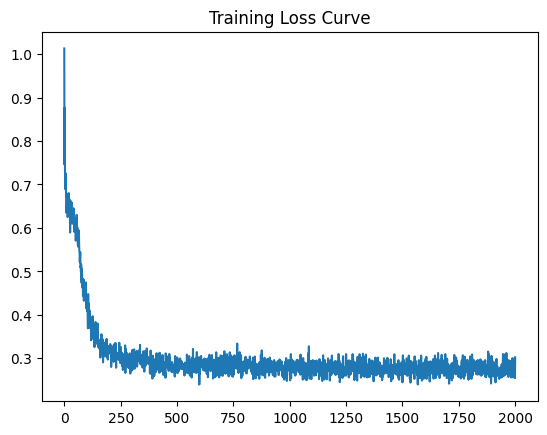

In [7]:
##### Question 4 #####
iterations = 2000
batchsize = 2048
input_dim = 2

##### Question 4: You need to implement these lines by yourself!! Around 3 lines (not necessarily)  #####
MLmodel = MLP().to('cuda')
optimizer = torch.optim.Adam(MLmodel.parameters(),lr = 1e-2)
VPmodel = VPSDE()
flow = ScoreMatch(MLmodel,VPmodel)
##### End of your implementation #####

loss_curve = flow.train(optimizer, samples_0, samples_1, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations + 1), loss_curve[:(iterations + 1)])
plt.title('Training Loss Curve')
plt.show()

0.949850


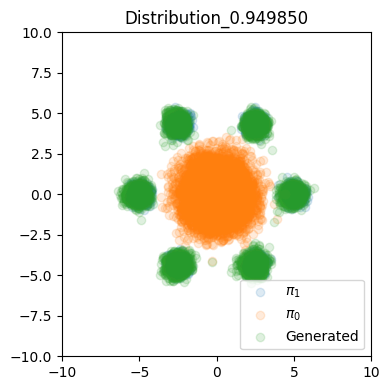

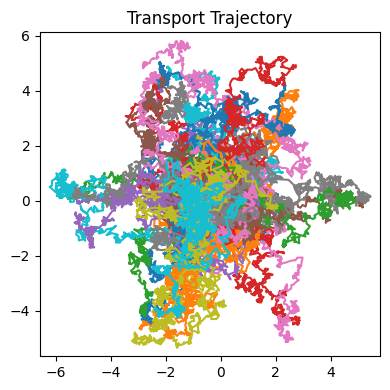

In [8]:
##### Question 5 #####
M = 10

##### Question 5: You need to implement these lines by yourself!! Only 1 line is needed. #####
traj = flow.sample(samples_0, N=1000)
##### End of your implementation #####

plt.figure(figsize=(4, 4))
plt.xlim(-M, M)
plt.ylim(-M, M)

plt.scatter(samples_1[:, 0].cpu().numpy(), samples_1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
ma = estimate_marginal_accuracy(samples_1, traj[-1])
plt.legend()
plt.title(f'Distribution_{ma:.6f}')
plt.tight_layout()

traj_particles = torch.stack(traj).cpu().numpy()
plt.figure(figsize=(4, 4))
plt.xlim(-M, M)
plt.ylim(-M, M)
plt.axis('equal')
for i in range(30):
    plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
plt.title('Transport Trajectory')
plt.tight_layout()
plt.show()